<a href="https://colab.research.google.com/github/stahelin/puc_data_science/blob/main/Diego_Stahelin_PUC_Data_Science_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Objetivo

Avaliar o uso de modelos ML e DL para prever preços diários de milho e compará-los com modelos econométricos tradicionais.



---



#2. Coleta e processamento de dados

# Imports

In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
# Function to convert strings with commas into floats
def convert_number(value):
    return float(value.replace(',', '.'))

# Download and read the CSV file as a DataFrame
url = "https://raw.githubusercontent.com/stahelin/puc_data_science/main/Milho_NY_%20Futuros.csv"
data = pd.read_csv(url, sep=';', quoting=1)

# Rename columns to make work easier
data = data.rename(columns={'Data': 'Date',
                            'Último': 'Close',
                            'Abertura': 'Open',
                            'Máxima': 'High',
                            'Mínima': 'Low',
                            'Vol.': 'Volume',
                            'Var%': 'Change'})

# Convert column 'Date' to type datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')


# Convert numeric columns to floats
data['Close'] = data['Close'].apply(convert_number)
data['Open'] = data['Open'].apply(convert_number)
data['High'] = data['High'].apply(convert_number)
data['Low'] = data['Low'].apply(convert_number)

data = data.dropna()
# OHLC chart
fig_ohlc = go.Figure(data=go.Ohlc(x=data['Date'],
                                  open=data['Open'],
                                  high=data['High'],
                                  low=data['Low'],
                                  close=data['Close']))

fig_ohlc.update_layout(title='Preços de Milho NY Futuros - Gráfico OHLC',
                       xaxis_title='Data',
                       yaxis_title='Preço')

fig_ohlc.show()


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4949 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4949 non-null   datetime64[ns]
 1   Close   4949 non-null   float64       
 2   Open    4949 non-null   float64       
 3   High    4949 non-null   float64       
 4   Low     4949 non-null   float64       
 5   Volume  4949 non-null   object        
 6   Change  4949 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 309.3+ KB
None


---
#3. Exploratory data analysis

### Quick DataFrame look

In [4]:
data = data.set_index("Date")
data.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-08-26,668.75,657.00,671.00,654.75,"75,54","1,71%"
2022-08-25,657.50,665.00,674.25,656.75,"78,32","-1,24%"
2022-08-24,665.75,659.75,675.50,655.75,"76,02","0,87%"
2022-08-23,660.00,637.00,666.75,635.75,"95,35","4,18%"
2022-08-22,633.50,622.75,635.25,618.00,"67,38","1,20%"


In [5]:
print("Lowest Price for the full dataframe = " , data["Low"].min())
print("Highest Price for the full dataframe = ", data["High"].max())

Lowest Price for the full dataframe =  199.5
Highest Price for the full dataframe =  849.0


In [6]:
def convert_volume_to_int(volume):
    volume = volume.replace(',', '')  # Replace comma with dot for decimal point
    return int(volume)

data["Volume"] = data["Volume"].apply(convert_volume_to_int)

### Volume of Transactions daily

<Axes: xlabel='Date'>

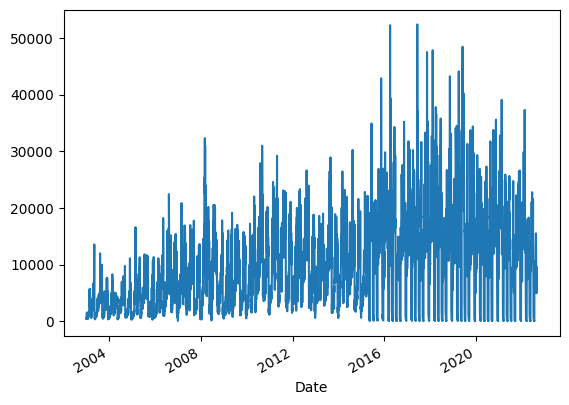

In [7]:
data["Volume"].plot(kind = "line")

In [8]:
print("Average Volume of Transactions = ", data["Volume"].mean())

Average Volume of Transactions =  9581.637502525762


---
#4. Data pre-processing


## Dropuing Unwanted Columns

In [9]:
data = data.drop(["Open","High","Low","Volume","Change"], axis = 1)

## Reversing dataframe to sort dates

In [10]:
data = data[::-1]

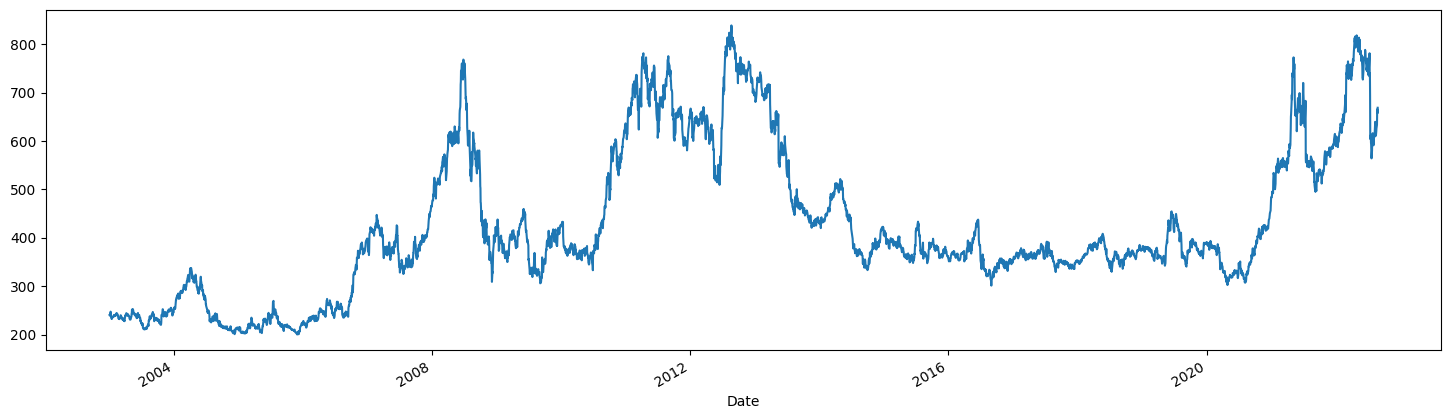

In [11]:
data["Close"].plot(figsize = (18,5));

In [12]:
look_back_time = 30
forward_time = 1

## defining division to be 20% of data
division =  (len(data) // 5)

scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(np.expand_dims(data["Close"].values, 1))

train_data = data.iloc[: 3* division]
val_data = data.iloc[3*division: 4*division]
test_data = data.iloc[4*division:]

def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]

    ## Preprocessing data for defining inputs and outputs
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])

    return np.array(X),np.array(Y)

train = processData(train_data,look_back_time, forward_time,1 )
val = processData(val_data,look_back_time, forward_time,1 )
test = processData(test_data,look_back_time, forward_time,1 )

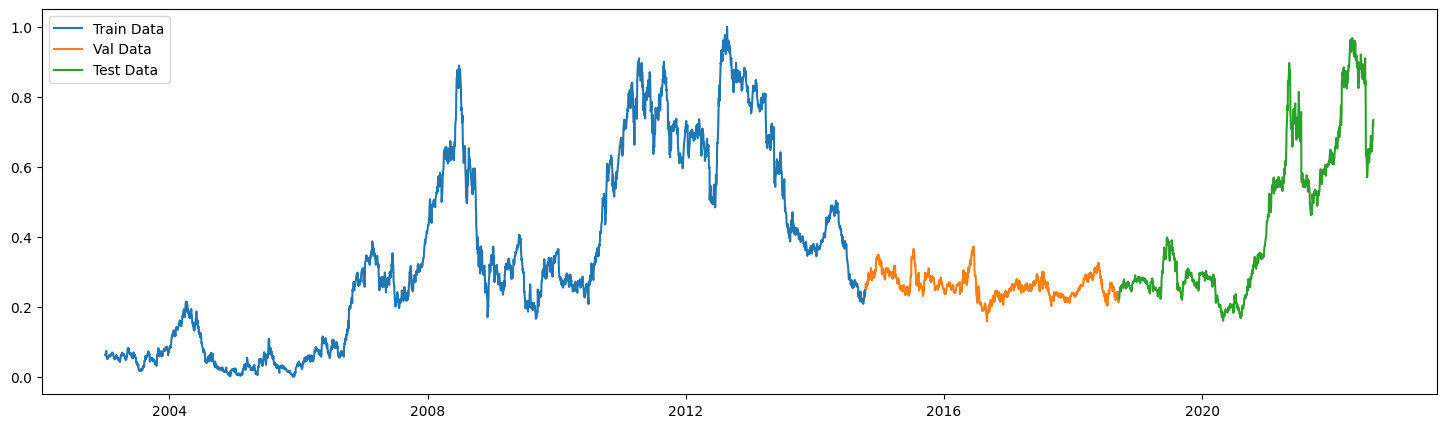

In [13]:
fig, ax = plt.subplots(figsize = (18,5))
plt.plot(train_data, label = "Train Data")
plt.plot(val_data, label = "Val Data")
plt.plot(test_data, label = "Test Data")
plt.legend();

---
#5. Implementation of models and analysis of hyperparameters


1. Econometrics: ARIMA and SARIMA
2. ML: SVR and AdaBoost
3. DL: LSTM
4. Ensembles:
     4.1 E1 (AdaBoost + SVR)
     4.2 E2 (SVR + LSTM
     4.3 E3 (AdaBoost + LSTM)

# Econometrics

### Data Processing for Econometrics models

In [14]:
train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')

## ARIMA

In [15]:
arima_model = ARIMA(train_data["Close"], order=(1, 0, 0))
arima_model_fit = arima_model.fit()

In [16]:
arima_predictions_val = arima_model_fit.predict(start=val_data.index[0], end=val_data.index[-1])
arima_predictions_val = scaler.inverse_transform(arima_predictions_val.values.reshape(1,-1)).squeeze()
arima_predictions_test =  arima_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
arima_predictions_test = scaler.inverse_transform(arima_predictions_test.values.reshape(1,-1)).squeeze()

## Post Processing for Predicions


In [17]:
def create_date_range(start_date, end_date):
    date_format = "%Y-%m-%d"  # Specify the format of your date strings
    step = timedelta(days=1)  # Define the step size as one day

    date_range = []
    current_date = start_date
    while current_date <= end_date:
        date_range.append(current_date.strftime(date_format))
        current_date += step

    return date_range

start_date = val_data.index.min()
end_date = val_data.index.max()
range_list_val = create_date_range(start_date, end_date)

start_date = test_data.index.min()
end_date = test_data.index.max()
range_list_test = create_date_range(start_date, end_date)

In [18]:
val_preds_df = pd.DataFrame(arima_predictions_val, columns = ["preds"], index = range_list_val)
val_preds_df.index = pd.to_datetime(val_preds_df.index)
val_preds_df = val_preds_df.loc[val_data.index]

test_preds_df = pd.DataFrame(arima_predictions_test, columns = ["preds"], index = range_list_test)
test_preds_df.index = pd.to_datetime(test_preds_df.index)
test_preds_df = test_preds_df.loc[test_data.index]

In [19]:
y_val = scaler.inverse_transform(val_data["Close"].values.reshape(1,-1)).squeeze()
ari_preds_val = val_preds_df["preds"].values

y_test = scaler.inverse_transform(test_data["Close"].values.reshape(1,-1)).squeeze()
ari_preds_test = test_preds_df["preds"].values

mse_val = mean_squared_error(val_data, ari_preds_val)
mae_val = mean_absolute_error(y_val, ari_preds_val)
r2_val = r2_score(y_val, ari_preds_val)

mse_test = mean_squared_error(y_test, ari_preds_test)
mae_test = mean_absolute_error(y_test, ari_preds_test)
r2_test = r2_score(y_test, ari_preds_test)

print("Validation Set (ARIMA):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Test Set (ARIMA):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Validation Set (ARIMA):
MSE: 177215.33098092774
MAE: 54.23929827772885
R2 Score: -6.285277332303286
Test Set (ARIMA):
MSE: 23357.712295189518
MAE: 117.42746853902253
R2 Score: -0.15437408977735556


## SARIMA

In [20]:
sarima_model = SARIMAX(train_data, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))  # Example order: SARIMA(1, 0, 0)(0, 0, 0, 0)
sarima_model_fit = sarima_model.fit()

In [21]:
sarima_predictions_val = sarima_model_fit.predict(start=val_data.index[0], end=val_data.index[-1])
sarima_predictions_val = scaler.inverse_transform(sarima_predictions_val.values.reshape(1,-1)).squeeze()
sarima_predictions_test =  sarima_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
sarima_predictions_test = scaler.inverse_transform(sarima_predictions_test.values.reshape(1,-1)).squeeze()

In [22]:
val_preds_df = pd.DataFrame(sarima_predictions_val, columns = ["preds"], index = range_list_val)
val_preds_df.index = pd.to_datetime(val_preds_df.index)
val_preds_df = val_preds_df.loc[val_data.index]

test_preds_df = pd.DataFrame(sarima_predictions_test, columns = ["preds"], index = range_list_test)
test_preds_df.index = pd.to_datetime(test_preds_df.index)
test_preds_df = test_preds_df.loc[test_data.index]

In [23]:
y_val = scaler.inverse_transform(val_data["Close"].values.reshape(1,-1)).squeeze()
sari_preds_val = val_preds_df["preds"].values

y_test = scaler.inverse_transform(test_data["Close"].values.reshape(1,-1)).squeeze()
sari_preds_test = test_preds_df["preds"].values

mse_val = mean_squared_error(val_data, sari_preds_val)
mae_val = mean_absolute_error(y_val, sari_preds_val)
r2_val = r2_score(y_val, ari_preds_val)

mse_test = mean_squared_error(y_test, sari_preds_test)
mae_test = mean_absolute_error(y_test, sari_preds_test)
r2_test = r2_score(y_test, sari_preds_test)

print("Validation Set (SARIMA):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Test Set (SARIMA):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Validation Set (SARIMA):
MSE: 68728.39209859073
MAE: 105.1481971999079
R2 Score: -6.285277332303286
Test Set (SARIMA):
MSE: 83328.42769987445
MAE: 248.36790640551354
R2 Score: -3.1182191416250706


# ML

### Data Processing for ML Models

In [24]:
X_train = train[0].reshape(train[0].shape[0],train[0].shape[1])
y_train = train[1].squeeze()

X_val = val[0].reshape(val[0].shape[0],val[0].shape[1])
y_val = val[1].squeeze()

X_test = test[0].reshape(test[0].shape[0],test[0].shape[1])
y_test = test[1].squeeze()

## Support Vector Regression (SVR)

In [25]:
svr_model = SVR()
svr_model.fit(X_train, y_train)

svr_predictions_val = svr_model.predict(X_val)
svr_predictions_val = scaler.inverse_transform(svr_predictions_val.reshape(1,-1)).squeeze()
svr_predictions_test =  svr_model.predict(X_test)
svr_predictions_test = scaler.inverse_transform(svr_predictions_test.reshape(1,-1)).squeeze()

In [26]:
mse_val = mean_squared_error(y_val, svr_predictions_val)
mae_val = mean_absolute_error(y_val, svr_predictions_val)
r2_val = r2_score(y_val, svr_predictions_val)

mse_test = mean_squared_error(y_test, svr_predictions_test)
mae_test = mean_absolute_error(y_test, svr_predictions_test)
r2_test = r2_score(y_test, svr_predictions_test)

print("Validation Set (SVR):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Test Set (SVR):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Validation Set (SVR):
MSE: 125894.04810881981
MAE: 354.1986974480188
R2 Score: -107770873.8324862
Test Set (SVR):
MSE: 243541.53237535327
MAE: 472.5965586684679
R2 Score: -4855108.298761955


## AdaBoost Regressor

In [27]:
adaboost_model = AdaBoostRegressor()
adaboost_model.fit(X_train, y_train)

ada_predictions_val = adaboost_model.predict(X_val)
ada_predictions_val = scaler.inverse_transform(ada_predictions_val.reshape(1,-1)).squeeze()
ada_predictions_test =  adaboost_model.predict(X_test)
ada_predictions_test = scaler.inverse_transform(ada_predictions_test.reshape(1,-1)).squeeze()

In [28]:
mse_val = mean_squared_error(y_val, ada_predictions_val)
mae_val = mean_absolute_error(y_val, ada_predictions_val)
r2_val = r2_score(y_val, ada_predictions_val)

mse_test = mean_squared_error(y_test, ada_predictions_test)
mae_test = mean_absolute_error(y_test, ada_predictions_test)
r2_test = r2_score(y_test, ada_predictions_test)

print("Validation Set (AdaBoostRegressor):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Test Set (AdaBoostRegressor):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Validation Set (AdaBoostRegressor):
MSE: 137100.04844293254
MAE: 369.79268076254806
R2 Score: -117363705.88072227
Test Set (AdaBoostRegressor):
MSE: 253522.56341601582
MAE: 483.65009694777825
R2 Score: -5054084.613578214


# DL

In [29]:
def lstm_model(forward_time):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape = [None,1]),
            tf.keras.layers.LSTM(
                64,
                return_sequences = True
            ),
            tf.keras.layers.LSTM(
                32,
                return_sequences = False
            ),
            tf.keras.layers.Dense(
                1024,
                activation = "relu"
            ),
            tf.keras.layers.Dropout(
                0.3
            ),
            tf.keras.layers.Dense(forward_time)
        ]
    )
    model.compile(
        loss='mean_squared_error',
        optimizer= tf.keras.optimizers.Adam()
    )
    return model

In [33]:
model = lstm_model(forward_time)
history = model.fit(
        train[0],
        train[1],
        validation_data = (val[0], val[1], ),
        epochs = 20,
        shuffle = True,
        batch_size  = 128,
        verbose = 1
    )

Epoch 1/20
23/23 [==============================] - 7s 93ms/step - loss: 0.0386 - val_loss: 0.0039
Epoch 2/20
23/23 [==============================] - 1s 58ms/step - loss: 0.0031 - val_loss: 4.5472e-04
Epoch 3/20
23/23 [==============================] - 1s 56ms/step - loss: 0.0018 - val_loss: 3.6247e-04
Epoch 4/20
23/23 [==============================] - 1s 63ms/step - loss: 0.0017 - val_loss: 3.5616e-04
Epoch 5/20
23/23 [==============================] - 1s 56ms/step - loss: 0.0016 - val_loss: 3.8770e-04
Epoch 6/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0015 - val_loss: 3.5731e-04
Epoch 7/20
23/23 [==============================] - 1s 50ms/step - loss: 0.0013 - val_loss: 2.7929e-04
Epoch 8/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0013 - val_loss: 2.6465e-04
Epoch 9/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0012 - val_loss: 2.4888e-04
Epoch 10/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0

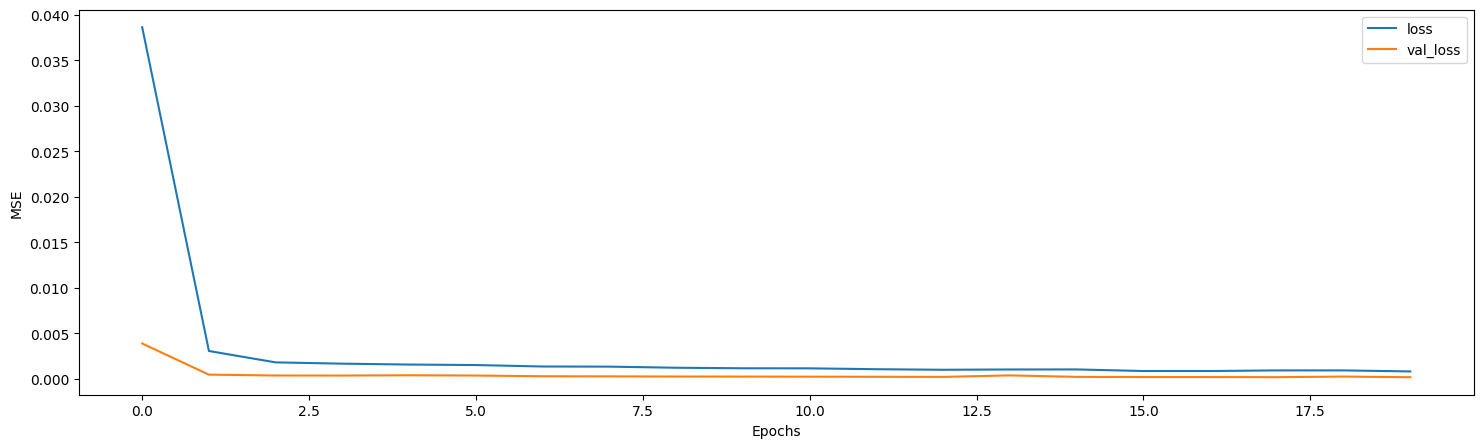

In [34]:
pd.DataFrame(history.history).plot(figsize = (18,5))
plt.xlabel("Epochs")
plt.ylabel("MSE");

In [32]:
train_preds = model.predict(train[0]).flatten()
train_data["pred"] = 0
train_data = train_data.reset_index()
train_data.loc[:look_back_time, "pred"] = np.nan
train_data.loc[look_back_time:, "pred"] = train_preds
train_data = train_data.set_index("Date")

train_data["pred"] = scaler.inverse_transform(train_data["pred"].values.reshape(1,-1)).squeeze()
train_data["lstm_price"] = scaler.inverse_transform(train_data["Close"].values.reshape(1,-1)).squeeze()

val_preds = model.predict(val[0]).flatten()
val_data["pred"] = 0
val_data = val_data.reset_index()
val_data.loc[:look_back_time, "pred"] = np.nan
val_data.loc[look_back_time:, "pred"] = val_preds
val_data = val_data.set_index("Date")

val_data["pred"] = scaler.inverse_transform(val_data["pred"].values.reshape(1,-1)).squeeze()
val_data["lstm_price"] = scaler.inverse_transform(val_data["Close"].values.reshape(1,-1)).squeeze()


test_preds = model.predict(test[0]).flatten()
test_data["pred"] = 0
test_data = test_data.reset_index()
test_data.loc[:look_back_time, "pred"] = np.nan
test_data.loc[look_back_time:, "pred"] = test_preds
test_data =test_data.set_index("Date")

test_data["pred"] = scaler.inverse_transform(test_data["pred"].values.reshape(1,-1)).squeeze()
test_data["lstm_price"] = scaler.inverse_transform(test_data["Close"].values.reshape(1,-1)).squeeze()

12/30 [===========>..................] - ETA: 0s

<ipython-input-32-8c0a3d2aef74>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



13/31 [===========>..................] - ETA: 0s

<ipython-input-32-8c0a3d2aef74>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



31/31 [==============================] - 0s 9ms/step


<ipython-input-32-8c0a3d2aef74>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



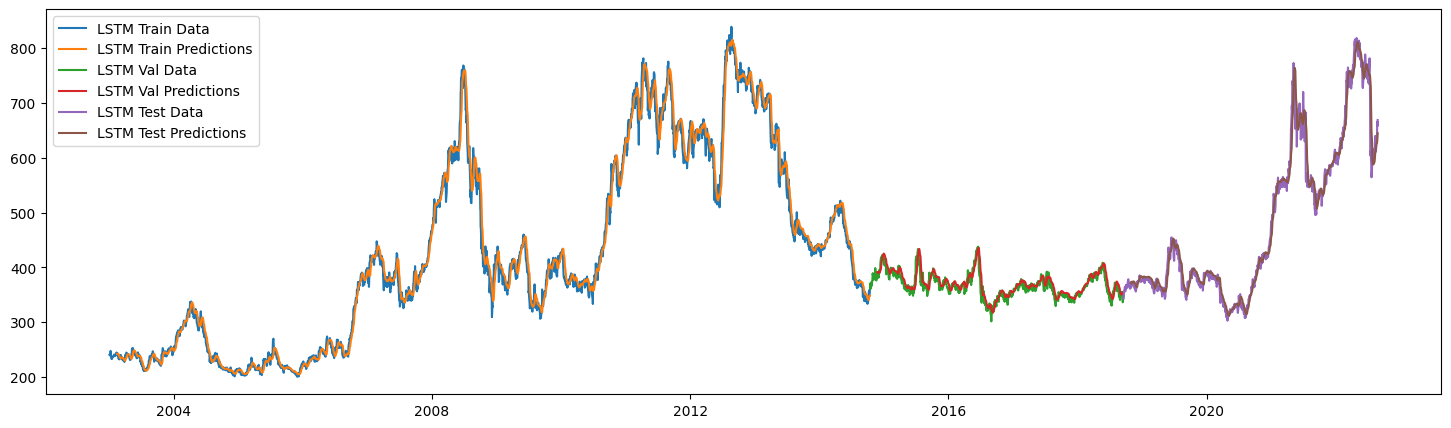

In [35]:
fig, ax = plt.subplots(figsize = (18,5))
train_data.index = train_data.index.to_timestamp()
plt.plot(train_data.index, train_data["lstm_price"], label = "LSTM Train Data")
plt.plot(train_data.index, train_data["pred"], label = "LSTM Train Predictions")


plt.plot(val_data.index, val_data["lstm_price"], label = "LSTM Val Data")
plt.plot(val_data.index, val_data["pred"], label = "LSTM Val Predictions")

plt.plot(test_data.index, test_data["lstm_price"], label = "LSTM Test Data")
plt.plot(test_data.index, test_data["pred"], label = "LSTM Test Predictions")

plt.legend()

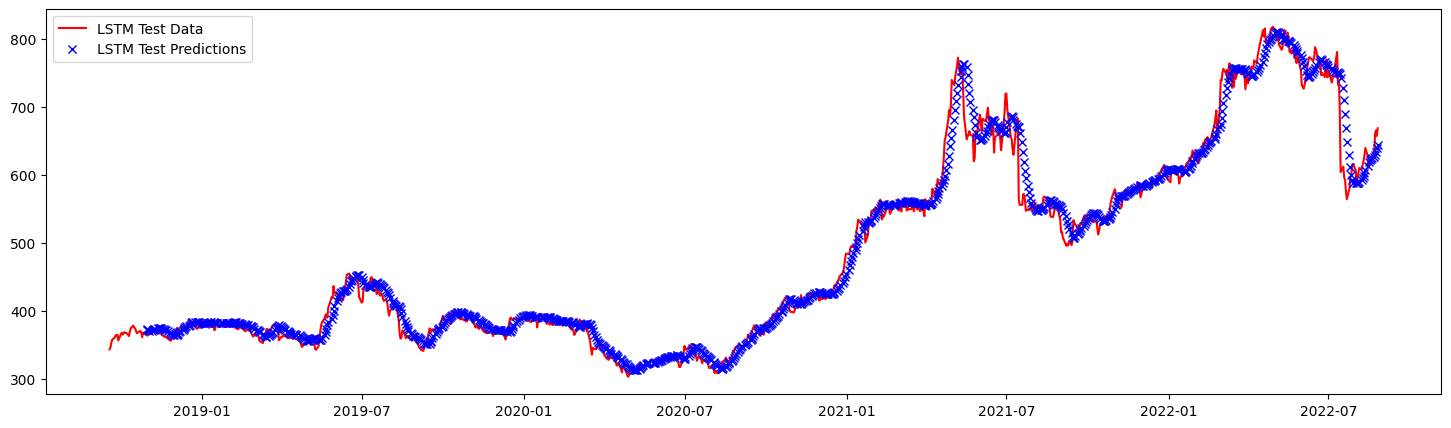

In [36]:
test_data["pred"] = 0
test_data = test_data.reset_index()
test_data.loc[:look_back_time, "pred"] = np.nan
test_data.loc[look_back_time:, "pred"] = test_preds[:len(test_data.loc[look_back_time:, "pred"])]
test_data = test_data.set_index("Date")

test_data["pred"] = scaler.inverse_transform(test_data["pred"].values.reshape(1,-1)).squeeze()
test_data["lstm_price"] = scaler.inverse_transform(test_data["Close"].values.reshape(1,-1)).squeeze()

fig, ax = plt.subplots(figsize = (18,5))

plt.plot(test_data.index, test_data["lstm_price"], label = "LSTM Test Data" ,color='red')
plt.plot(test_data.index, test_data["pred"], label = "LSTM Test Predictions",color='blue', marker='x',linestyle = 'None')
plt.legend()

In [37]:
print("Validation Set (AdaBoostRegressor):")
actual_price = val_data.dropna()["lstm_price"].values
predicted_price = val_data.dropna()["pred"].values

print("MAE Error = ", mean_absolute_error(actual_price, predicted_price))
print("RMSE Error = ", mean_squared_error(actual_price, predicted_price, squared=False))
print("R2 Scode = ", r2_score(actual_price, predicted_price))

print("Test Set (AdaBoostRegressor):")
actual_price = test_data.dropna()["lstm_price"].values
predicted_price = test_data.dropna()["pred"].values

print("MAE Error = ", mean_absolute_error(actual_price, predicted_price))
print("RMSE Error = ", mean_squared_error(actual_price, predicted_price, squared=False))
print("R2 Scode = ", r2_score(actual_price, predicted_price))

Validation Set (AdaBoostRegressor):
MAE Error =  7.785319654820689
RMSE Error =  10.521473081224284
R2 Scode =  0.7673689613908593
Test Set (AdaBoostRegressor):
MAE Error =  12.691905788145002
RMSE Error =  19.881522146035778
R2 Scode =  0.9806561198587765


# 4. Ensemble

## 4.1 E1 (AdaBoost + SVR)

In [38]:
ens_1_val = (svr_predictions_val + ada_predictions_val)/2
ens_1_test = (svr_predictions_test + ada_predictions_test)/2
mse_val = mean_squared_error(y_val, ens_1_val)
mae_val = mean_absolute_error(y_val, ens_1_val)
r2_val = r2_score(y_val, ens_1_val)

mse_test = mean_squared_error(y_test, ens_1_test)
mae_test = mean_absolute_error(y_test, ens_1_test)
r2_test = r2_score(y_test, ens_1_test)

print("Ensemble (AdaBoost + SVR):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Ensemble (AdaBoost + SVR):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Ensemble (AdaBoost + SVR):
MSE: 131401.6655449578
MAE: 361.9956891052834
R2 Score: -112485638.01913133
Ensemble (AdaBoost + SVR):
MSE: 248432.83093302898
MAE: 478.1233278081231
R2 Score: -4952618.521674536


 ## 4.2 E2 (SVR + LSTM)

In [39]:
lstm_predictions_val = val_data["pred"].dropna().values
lstm_predictions_test = test_data["pred"].dropna().values

In [40]:
ens_2_val = (svr_predictions_val + lstm_predictions_val)/2
ens_2_test = (svr_predictions_test + lstm_predictions_test)/2
mse_val = mean_squared_error(y_val, ens_2_val)
mae_val = mean_absolute_error(y_val, ens_2_val)
r2_val = r2_score(y_val, ens_2_val)

mse_test = mean_squared_error(y_test, ens_2_test)
mae_test = mean_absolute_error(y_test, ens_2_test)
r2_test = r2_score(y_test, ens_2_test)

print("Ensemble (SVR + LSTM):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Ensemble (SVR + LSTM):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Ensemble (SVR + LSTM):
MSE: 131808.95636169962
MAE: 362.4570702307172
R2 Score: -112834296.97712722
Ensemble (SVR + LSTM):
MSE: 249844.9817056823
MAE: 479.33045745314064
R2 Score: -4980770.378488002


 ## 4.3 E3 (AdaBoost + LSTM)

In [41]:
ens_3_val = (ada_predictions_val + lstm_predictions_val)/2
ens_3_test = (ada_predictions_test + lstm_predictions_test)/2
mse_val = mean_squared_error(y_val, ens_3_val)
mae_val = mean_absolute_error(y_val, ens_3_val)
r2_val = r2_score(y_val, ens_3_val)

mse_test = mean_squared_error(y_test, ens_3_test)
mae_test = mean_absolute_error(y_test, ens_3_test)
r2_test = r2_score(y_test, ens_3_test)

print("Ensemble (AdaBoost + LSTM):")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("R2 Score:", r2_val)

print("Ensemble (AdaBoost + LSTM):")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2 Score:", r2_test)

Ensemble (AdaBoost + LSTM):
MSE: 137471.3101204234
MAE: 370.2540618879819
R2 Score: -117681522.30156198
Ensemble (AdaBoost + LSTM):
MSE: 254839.59092783902
MAE: 484.85722659279577
R2 Score: -5080340.145671702
